# Application: Google's PageRank Algorithm

One of the most famous and influential applications of sparse matrices and graph theory is the PageRank (PR) algorithm, which was the original basis for Google's search engine rankings.

PageRank works by assigning an "importance" score to every page on the web. It does this by counting the number *and quality* of links to a page. The core idea is that a link from an important page is worth more than a link from an unimportant one.

The PageRanks for an example network are shown below. Page C has a higher PageRank than Page E, even though it has fewer incoming links. This is because the one link to C comes from Page B, which is itself an important page.

![PageRanks-Example.png](pageranks-example.png "PageRank example")

(from <https://en.wikipedia.org/wiki/PageRank>)

## The PageRank Algorithm

We can model the entire web as a massive, sparse, directed graph where each web page is a **vertex** and each hyperlink is an **edge**.

### The "Random Surfer" Model

PageRank is best understood through the "random surfer" model. Imagine a person randomly clicking links on the web. The PageRank of a page $i$, $PR(i)$, is the probability that this random surfer will be on page $i$ at any given moment.

A surfer on a page $j$ can do one of two things:
1.  With probability $d$ (the *damping factor*, usually ~0.85), they **click a random link** on that page. If page $j$ has $L(j)$ outgoing links, they will land on page $i$ (where $j \to i$) with probability $d \cdot \frac{PR(j)}{L(j)}$.
2.  With probability $1-d$, they **get bored and "teleport"** to *any* random page on the web, landing on page $i$ with probability $\frac{1-d}{N}$, where $N$ is the total number of pages.

### The Power Iteration

Combining these two ideas gives the PageRank equation for a page $i$:

$$
PR(i) = \frac{1-d}{N} + d \sum_{j \text{ s.t. } j \to i} \frac{PR(j)}{L(j)}
$$

This is a massive system of linear equations! But we can solve it easily using the **power iteration** method. We start with an initial guess for the PageRank vector $R$ (e.g., $R_i = 1/N$ for all $i$) and then iteratively update it using the formula above until it converges.

We can write this update in matrix form:

$$ R_{\text{new}} = \frac{1-d}{N}\mathbf{1} + d \cdot M \cdot R_{\text{old}} $$

Where:
* $R$ is the $N \times 1$ vector of PageRanks.
* $\mathbf{1}$ is an $N \times 1$ vector of all ones.
* $M$ is the $N \times N$ sparse **transition matrix**. $M_{ij} = 1/L(j)$ if there is a link from $j$ to $i$, and 0 otherwise. This is the transpose of the (normalized) adjacency matrix!

### Creating the Adjacency Matrix

Let's compute the PageRank for the graph shown above. First, we build the $N \times N$ adjacency matrix $A$, where $A_{ij}=1$ if there is an edge *from* $i$ *to* $j$. We build this using the COO-to-CSC constructor.

In [1]:
using Plots, SparseArrays, LinearAlgebra # Load all required packages

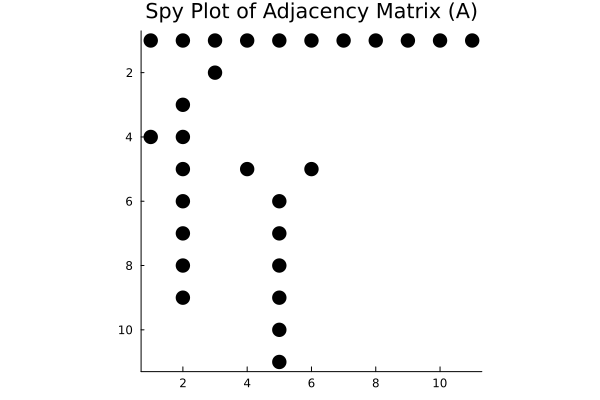

In [2]:
# Define the edges (from -> to)
rows_i = [2,3,4,4,5,5,5,6,6,7,7,8,8,9,9,10,11] # 'from' vertex (row index)
cols_j = [3,2,1,2,2,4,6,2,5,2,5,2,5,2,5,5,5]   # 'to' vertex (col index)

# Create the 6x6 adjacency matrix A (A_ij = 1 if i -> j)
A = sparse(rows_i, cols_j, 1, 11, 11)

# Get L(i), the number of *outbound* links for each page i
# We sum across the columns (dims=2) for each row
L = sum(A, dims=2)[:]

# Handle "Dangling Nodes" (pages with no outbound links)
# If a page has no links (L[i]==0), the surfer gets trapped.
# We fix this by pretending it links to *all* pages (including itself).
# This means A[i,:] = 1, and L[i] will be N (which is 6).
A[L.==0, :] .= 1

# Display the 'fixed' adjacency matrix
spy(A, markersize=8, title="Spy Plot of Adjacency Matrix (A)")

### The PageRank Function

Now we implement the power iteration. The key step is creating the transition matrix $M$. 

We can get $M$ (where $M_{ij} = 1/L(j)$ if $j \to i$) by first normalizing $A$ (so $A_{ij} = 1/L(i)$ if $i \to j$) and then taking the **transpose**.

In [3]:
function pagerank(A, d=0.85, tol=1e-8)
    # Get N, the number of pages (A is NxN)
    N = size(A, 2)
    
    # Recalculate L, the out-degree vector (since A might have been fixed)
    L = sum(A, dims=2)
    
    # Create the column-stochastic transition matrix M
    # 1. (A ./ L) normalizes each row i by its out-degree L(i)
    #    (A ./ L)_ij = 1/L(i) if i -> j
    # 2. (...) ' takes the transpose.
    #    M_ji = 1/L(i) if i -> j. This is exactly M_ij = 1/L(j) if j -> i.
    M = (A ./ L)'
    
    # Start with an initial guess: uniform PageRank
    R = ones(N) / N
    
    # Iterate until convergence
    while true
        # The PageRank update formula!
        newR = d * (M * R) .+ (1 - d) / N
        
        # Check if the change is smaller than our tolerance
        if maximum(abs.(newR - R)) < tol
            return newR # Converged!
        end
        
        R = newR # Update for next iteration
    end
end

pagerank (generic function with 3 methods)

Finally, we can compute and display the PageRanks for our example network.

In [4]:
# Run the PageRank algorithm on our adjacency matrix A
ranks = pagerank(A)
round.(100ranks, digits=1) # Show percentages

11-element Vector{Float64}:
  3.3
 38.4
 34.3
  3.9
  8.1
  3.9
  1.6
  1.6
  1.6
  1.6
  1.6